# BERT 微调（句子的语法可接受性判断）
版权所有 2022-2023 Denis Rothman。文本单元格被取出并替换为单元格内每个单元格的标题。单元格的标题指的是书中各节的标题。单元格的描述已被重写以用于教育目的。

本笔记本展示了如何微调 Transformer 模型。许多经过预训练和微调的 Transformer 模型可在线获得。有些模型，例如 GPT-3，甚至不需要微调。这些现成的模型甚至可以通过 API 访问。

但是，强烈建议您了解本笔记本以掌握 Transformer 模型的架构。

贡献者：George Mihaila

[Chris McCormick 和 Nick Ryan 的参考笔记本](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX)

[参考 Chris McCormick 和 Nick Rya 的文章](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

#一、环境配置

In [ ]:
from IPython.display import Image     #这用于在笔记本中渲染图像

In [ ]:
#@title 安装 Bert 的 Hugging Face PyTorch 接口
try:
  import transformers
except:
  print("Installing transformers")
  !pip -q install transformers

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange # 导入进度条模块
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title 指定Torch使用的硬件
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Fri Mar 28 16:12:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.47                 Driver Version: 572.47         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0             26W /  102W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#二、数据处理

##1、加载CoLA数据集

In [ ]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "in_domain_train.tsv"
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: raw.githubusercontent.com
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: raw.githubusercontent.com


> TSV格式文件是一种用于储存数据的文本格式文件其数据以表格结构（例如数据库 或电子表格 数据）储存
    每一行储存一条记录每条记录的各个字段间以制表符作为分隔
1.   第一列：句子来源（用编号表示）
2.   第二列：标注（0=不可接受，1=可接受）
3.   第三列：作者的标注
4.   第四列：要分类的句子

In [ ]:
# 数据集来源 : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [ ]:
df.sample(10)

,sentence_source,label,label_notes,sentence
6705,m_02,0,*,too much vehicles are damaged by salt .
153,cj99,0,?*,"i can well imagine if he eats more , him getti..."
6588,g_81,1,NaN,the woman who was here believed that the man w...
112,cj99,1,NaN,"i demand that the more john eats , the more he..."
8305,ad03,1,NaN,burn letters to peter !
523,bc01,1,NaN,the stone knocked the pole into the road .
1893,r-67,1,NaN,there are seven holes in the door and window .
4872,ks08,1,NaN,the student who won the prize left .
7454,sks13,0,*,i wonder whether has mary worked for microsoft .
8528,ad03,1,NaN,gilgamesh fears death and achilles does as well


##2、创建（句子、标签）列表、在每个句子前后添加BERT的 CLS 和 SEP 标记

In [ ]:
sentences = df.sentence.values

# 在 BERT 的每个句子的开头和结尾添加 CLS 和 SEP 标记
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

###查看数据

In [ ]:
print(type(sentences))
print(type(labels))

<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
import random
# list随机取样
random.sample(sentences, 5)

['[CLS] the bus hopes to be here at five . [SEP]',
 '[CLS] for mary to love that boor is a travesty . [SEP]',
 '[CLS] any senator becomes more corrupt , the more lobbyists he talks to . [SEP]',
 '[CLS] like the ice cream . [SEP]',
 '[CLS] it is important for you to be more careful , the more you eat . [SEP]']

In [ ]:
# numpy.ndarray随机取样
np.random.choice(labels, size=5, replace=False)

array([1, 1, 1, 1, 1], dtype=int64)

##3、预训练BERT模型进行分词操作

In [ ]:
#@title 加载bert基座模型
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    print("Tokenizer downloaded successfully.")
except Exception as e:
    print("An error occurred while downloading the tokenizer.")
    print(str(e))
    import traceback
    print(traceback.format_exc())

Tokenizer downloaded successfully.


In [ ]:
#@title 分词操作
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [ ]:
print(f"第一个句子的分词结果：\n{tokenized_texts[0]}")

第一个句子的分词结果：
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


##4、数据填充

In [ ]:
#@title 对BERT模型进行微调之前，需要将数据集中的句子进行填充，补齐到统一长度

MAX_LEN = 128

# convert_tokens_to_ids() 的作用是：将 token 变成BERT词汇表中的索引号
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 将数据集中的句子填充（截断）到MAX_LEN的长度
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
input_ids[0]

array([  101,  2256,  2814, 24185,  1050,  1005,  1056,  4965,  2023,
        4106,  1010,  2292,  2894,  1996,  2279,  2028,  2057, 16599,
        1012,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

### 创建注意力掩码，防止模型对填充词进行注意力计算

首先创建一个空的attention_masks列表,用于存储每个序列的注意力掩码（与inputs_ids）对应

针对每个词元，判断索引是否大于0：如果大于0，对应位置的掩码值则为1，即有效词元；如果等于0，掩码值则为0，即填充词元

In [ ]:
attention_masks = []

# 为每个 token 创建一个由 1 组成的掩码，后面跟着 0 作为填充
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

####查看数据

In [ ]:
print(attention_masks[1][0:15])
print(input_ids[1][0:15])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
[  101  2028  2062 18404  2236  3989  1998  1045  1005  1049  3228  2039
  1012   102     0]


In [ ]:
print(input_ids[0])

[  101  2256  2814 24185  1050  1005  1056  4965  2023  4106  1010  2292
  2894  1996  2279  2028  2057 16599  1012   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [ ]:
print(labels[0])

1


In [ ]:
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


##5、划分数据集

将 input_ids 和 labels 按 9:1 比例拆分为训练集和验证集

    使用 train_test_split 将我们的数据分成训练集和验证集进行训练

    input_ids：BERT 词汇表索引的输入数据（句子转 token ID）
    labels：每个输入的标签（比如文本分类任务中的类别标签）
    test_size=0.1：10% 数据作为验证集，90% 作为训练集
    random_state=2018：保证每次划分结果一致（随机种子）

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks, random_state=2018, test_size=0.1)

###查看数据

In [ ]:
print(train_inputs[0])

[ 101 2002 2939 1996 3328 1012  102    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
print(train_labels[0])

1


In [ ]:
print(train_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


##6、数据放入dataloader中

In [ ]:
# Torch 张量是我们的模型所需的数据类型
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#三、BERT模型配置

In [ ]:
#@title 查看BERT模型配置
from transformers import BertModel, BertConfig
configuration = BertConfig()

# 从 bert-base-uncased 样式配置初始化模型
model = BertModel(configuration)

# 访问模型配置
configuration = model.config
print(configuration)

BertConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
#@title 加载Hugging Face BERT uncased base模型
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

In [ ]:
#@title 对初始化模型设置："权重衰减率"
# model.named_parameters() 获取 BERT 模型的所有参数，并返回一个列表，其中每个元素是 (参数名, 参数值) 这样的元组
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    # 过滤所有不包含“bias”、“gamma”、“beta”的参数
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1
    },

    # 过滤包含这些内容的参数
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0
    }
]
# Note - optimizer_grouped_pa​​rameters` 仅包含参数值，不包含参数名

代码来自于:
https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

```
# 这里定义了一个不需要进行权重衰减的参数列表：
# bias（偏差项）：通常不进行权重衰减，因为偏差项主要影响输出的平移，不会影响模型的复杂度。
# LayerNorm.weight（层归一化权重）：LayerNorm 层的参数通常也不需要进行 L2 正则化。

# 将“权重”参数与“偏差”参数分开.
# - 对于“权重”参数，‘weight_decay_rate’为 0.01
# - 对于‘bias’参数，‘weight_decay_rate’为 0.0
```



In [ ]:
for n, p in param_optimizer:
  print(n)

module.bert.embeddings.word_embeddings.weight
module.bert.embeddings.position_embeddings.weight
module.bert.embeddings.token_type_embeddings.weight
module.bert.embeddings.LayerNorm.weight
module.bert.embeddings.LayerNorm.bias
module.bert.encoder.layer.0.attention.self.query.weight
module.bert.encoder.layer.0.attention.self.query.bias
module.bert.encoder.layer.0.attention.self.key.weight
module.bert.encoder.layer.0.attention.self.key.bias
module.bert.encoder.layer.0.attention.self.value.weight
module.bert.encoder.layer.0.attention.self.value.bias
module.bert.encoder.layer.0.attention.output.dense.weight
module.bert.encoder.layer.0.attention.output.dense.bias
module.bert.encoder.layer.0.attention.output.LayerNorm.weight
module.bert.encoder.layer.0.attention.output.LayerNorm.bias
module.bert.encoder.layer.0.intermediate.dense.weight
module.bert.encoder.layer.0.intermediate.dense.bias
module.bert.encoder.layer.0.output.dense.weight
module.bert.encoder.layer.0.output.dense.bias
module.bert.

In [ ]:
#@title 设置训练的超参数
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - 默认值为 5e-5，我们的笔记本为 2e-5
                  eps = 1e-8 # args.adam_epsilon - 默认值为 1e-8。
                  )
# 总训练步数 = 批次数 * 训练周期
total_steps = len(train_dataloader) * epochs

# 创建学习率调度程序
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

C:\Users\31310\anaconda3\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#四、模型训练、评估

In [ ]:
#@title 度量准确率的函数
# 将预测结果与标注结果进行比较
def flat_accuracy(predictions, labels):
    predictions_flat = np.argmax(predictions, axis=1).flatten()  # np.argmax() 取出最大值所在的索引；axis=1 表示在行方向上取最大值的索引，即每个样本的预测类别
    labels_flat = labels.flatten()  # .flatten()：展平成一维数组
    return np.sum(predictions_flat == labels_flat) / len(labels_flat)

In [ ]:
#@title 训练、评估模型
# 存储我们的损失值和准确率以供绘图
train_loss_set = []

for _ in trange(epochs, desc="Epoch"):

  # 训练模式
  model.train()

  # 跟踪变量
  train_loss = 0
  nb_train_examples, nb_train_steps = 0, 0

  # 训练一个 epoch 的数据
  for step, batch in enumerate(train_dataloader):
    # 将每个批次数据放到device中
    batch = tuple(t.to(device) for t in batch)
    # 从数据加载器中解压输入
    batch_input_ids, batch_input_mask, batch_labels = batch
    # 清除梯度（默认情况下它们会累积）
    optimizer.zero_grad()
    # 前向传播
    outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels=batch_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    # 反向传播
    loss.backward()
    optimizer.step()    # 更新参数并使用计算的梯度采取下一步行动

    scheduler.step()    # 更新学习率

    # 更新跟踪变量
    train_loss += loss.item()
    nb_train_examples += batch_input_ids.size(0)
    nb_train_steps += 1

  print("Train loss: {}".format(train_loss/nb_train_steps))


  # 评估模式，评估验证集上的损失
  model.eval()

  # 跟踪变量
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # 评估一个周期的数据
  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)  # 将每个批次数据放到device中
    b_input_ids, b_input_mask, b_labels = batch   # 数据加载器中解压输入
    with torch.no_grad():# 不计算或存储梯度，节省内存并加快验证速度
      # 前向传递，预测数据标签（0/1）
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits['logits'].detach().cpu().numpy()  #将预测结果放到cpu上
    label_ids = b_labels.to('cpu').numpy()  #真实结果也放上去

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)  # 见度量准确率函数

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("\nValidation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|                                                                                     | 0/4 [00:00<?, ?it/s]

Train loss: 0.4853630593950818


Epoch:  25%|███████████████████                                                         | 1/4 [13:17<39:52, 797.54s/it]


Validation Accuracy: 0.8186728395061729
Train loss: 0.2775346376156411


Epoch:  50%|██████████████████████████████████████                                      | 2/4 [26:38<26:38, 799.45s/it]


Validation Accuracy: 0.8260030864197531
Train loss: 0.16091634365594734


Epoch:  75%|█████████████████████████████████████████████████████████                   | 3/4 [39:55<13:18, 798.30s/it]


Validation Accuracy: 0.8283179012345678
Train loss: 0.09699402445795872


Epoch: 100%|████████████████████████████████████████████████████████████████████████████| 4/4 [53:08<00:00, 797.09s/it]


Validation Accuracy: 0.8275462962962963


In [ ]:
random.sample(train_loss_set, 10)

[0.18364395201206207,
 0.15345783531665802,
 0.16216272115707397,
 0.2670740485191345,
 0.5422934293746948,
 0.4471832513809204,
 0.2262093722820282,
 0.5363050699234009,
 0.2771269679069519,
 0.5171825289726257]

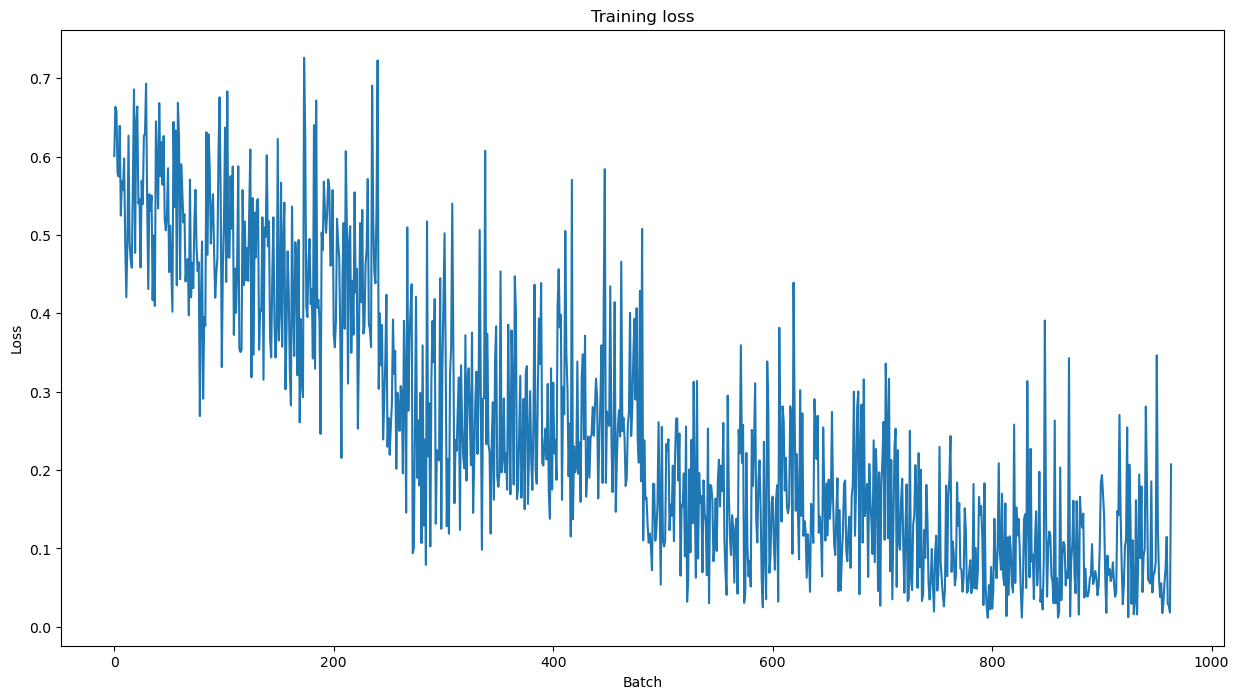

In [ ]:
#@title 训练评估
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

#五、模型测试

In [55]:
#@title 使用保留数据集进行预测和评估
# 同数据处理部分操作
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [56]:
#@title 测试数据集预处理
# 创建句子和标签列表
sentences = df.sentence.values

# 我们需要在每个句子的开头和结尾添加特殊标记，以使 BERT 正常工作，[CLS]、[SEP]
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# 使用 BERT 标记器将标记转换为 BERT 词汇表中的索引号
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# 填充输入标记
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# 创建注意力掩码
attention_masks = []

# 为每个 token 创建一个由 1 组成的掩码，后面跟着 0 作为填充
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

"""
为什么使用 SequentialSampler？
在 预测（inference）阶段，通常不需要打乱数据顺序。数据顺序的保持有时对于结果的可复现性有帮助。
训练时，我们通常使用 RandomSampler 来打乱数据，以防止模型陷入顺序性问题
但在 预测阶段，我们只需要按顺序从数据集中提取数据，SequentialSampler 就是为这种需求设计的。
"""
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
# 取样策略，顺序取样
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [57]:
# 测试集预测

# 将模型置于评估模式
model.eval()

# 跟踪变量
predictions , true_labels = [], []

# 预测
for batch in prediction_dataloader:
  # 将批次放入GPU中
  batch = tuple(t.to(device) for t in batch)
  # 从我们的数据加载器中解压输入
  b_input_ids, b_input_mask, b_labels = batch
  # 告诉模型不要计算或存储梯度，节省内存并加快预测速度
  with torch.no_grad():
    # 前向传播，计算 logit 预测
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # 将logits和labels移到CPU上
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # 存储预测和真实标签
  predictions.append(logits)
  true_labels.append(label_ids)

#六、使用Matthews相关系数进行评估

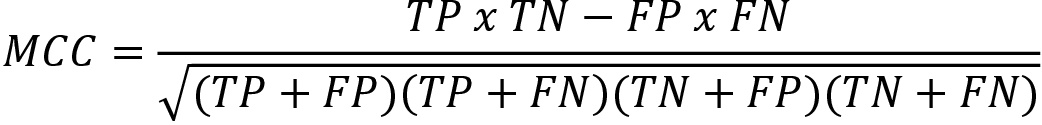

In [ ]:
Image('https://github.com/Denis2054/Transformers-for-NLP-2nd-Edition/raw/main/Notebook%20images/03/B17948_03_005.png', width=800) #This is used for rendering images in the notebook

In [58]:
#@title 使用Matthews相关系数进行评估
# 导入并使用Matthews相关系数评估每个测试批次
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

最终得分将基于整个测试集，但让我们看一下各个批次的得分，以了解批次之间指标的变化。

In [59]:
#@title 整个数据集上的Matthews评估
# 将预测值和真实值展平，以汇总Matthews对整个数据集的评估
# flat_predictions 会是一个一维列表，将所有嵌套的预测值展平成一个列表
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5187651504700211